## Importing Packages

In [260]:
import cv2
import os
import random
import gc #garbage collector for cleaning deleted data from memory
import glob
from pathlib import Path

import pandas as pd
import numpy as np

# Importing sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
%matplotlib inline

## Function Definitions

In [429]:
# Preprocessing images to get image array and their labels
def proc_images(im,lb):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = []
    y = []

    for i in range(len(im)):
        X.append(cv2.resize(cv2.imread(im[i],cv2.IMREAD_COLOR), (rows,cols), interpolation=cv2.INTER_CUBIC)) #(128,128,3)
        
        # 0 for not pikachu and 1 for pikachu images
        if('not' in lb[i]):
            y.append(0)
        else:
            y.append(1)
    return np.asarray(X),np.asarray(y)

# Normalizing the image data
def normalize(images):
    norm_images = []
    for img in images:
        norm_img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        norm_images.append(norm_img)
    return np.asarray(norm_images)

# Plot accuracy loss for model history
def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
## Model performance
def scores(y_test,test_pred):
    TP = FN = FP = TN = 0

    for j in range(len(y_test)):
        if y_test[j]== 1 and test_pred[j] == 1:
            TP = TP+1
        elif y_test[j]== 1 and test_pred[j] == 11:
            FN = FN+1
        elif y_test[j]== 0 and test_pred[j] == 1:
            FP = FP+1
        else:
            TN = TN +1
    return TP,FN,FP,TN



## Data Loading

In [53]:
ROOT = 'C:/Users/Sumi/Desktop/NOTES SEM2/cf_testing-master/pikachu/pikachu_dataset/'
pik_path = ROOT + 'pikachu/'
nopik_path = ROOT + 'not_pikachu/'
print(pik_path,"\n",nopik_path)

C:/Users/Sumi/Desktop/NOTES SEM2/cf_testing-master/pikachu/pikachu_dataset/pikachu/ 
 C:/Users/Sumi/Desktop/NOTES SEM2/cf_testing-master/pikachu/pikachu_dataset/not_pikachu/


In [347]:
pika_images = []
pikanames = []
pikalabels = []
for file in glob.glob(pik_path + "*.*g"):
    file = file.replace("\\",'/')
    pika_images.append(file)
    
random.shuffle(pika_images)

# Splitting the image names and folder names for labelling
for i in range(len(pika_images)):
    pikanames.append(os.path.basename(pika_images[i]))
    pikalabels.append(os.path.dirname(file).split('/')[-1])

# len(pika_images) # 483

nopika_images = []
nopikanames = []
nopikalabels = []
for file in glob.glob(nopik_path + "*.*g"):
    file = file.replace("\\",'/')
    nopika_images.append(file)
    
random.shuffle(nopika_images)

# Splitting the image names and folder names for labelling
for i in range(len(nopika_images)):
    nopikanames.append(os.path.basename(nopika_images[i]))
    nopikalabels.append(os.path.dirname(file).split('/')[-1])

# len(nopika_images) # 461

all_images = []
filenames = []
labels = []
for file in glob.glob(ROOT + "*/*.*g",recursive=True):
    file = file.replace("\\",'/')
    all_images.append(file)

# Random shuffling 
random.shuffle(all_images)

# Splitting the image names and folder names for labelling
for file in all_images:
    filenames.append(os.path.basename(file))
    labels.append(os.path.dirname(file).split('/')[-1])

In [338]:
# Image dimensions
rows = 128
cols = 128
channels = 3

In [361]:
print("\nAll Images:\n")
# X: images, y: labels (0: not pikachu, 1: pikachu )
X, y = proc_images(all_images, labels) 
print("Shape of X:",X.shape,"\nShape of y:",y.shape)

print("\nPikachu Images:\n")
# X1: pikachu images, y1: labels (1: pikachu ) as all are pikachu images
X1,y1 = proc_images(pika_images, pikalabels)
print("Shape of X1:",X1.shape,"\nShape of y1:",y1.shape)

print("\nNon Pikachu Images:\n")
# X2: non pikachu images, y2: labels (0: not pikachu ) as all are non pikachu images
X2,y2 = proc_images(nopika_images, nopikalabels)
print("Shape of X2:",X2.shape,"\nShape of y2:",y2.shape)



All Images:

Shape of X: (944, 128, 128, 3) 
Shape of y: (944,)

Pikachu Images:

Shape of X1: (483, 128, 128, 3) 
Shape of y1: (483,)

Non Pikachu Images:

Shape of X2: (461, 128, 128, 3) 
Shape of y2: (461,)


## divide the images into a train and test set

Training set: 400 pikachu images : **X_train**

Test observations/features: rest pikachu and all non pikachu images : **X_test**

Test labels: **y_test**

In [375]:
# Once class SVM is trained with the observations of only one class. 

# In this case, the algorithm is trained with random 400 images of pikachu. 
# The remaining images of pikachu are merged with the other non pikachu images to create a test set. 

X_train = X1[0:400]
y_train = y1[0:400]

X_test = np.concatenate((X1[400:], X2), axis=0)
y_test = np.concatenate((y1[400:], y2), axis=0)

print(" Shape of X_train:",X_train.shape, "\n Shape of X_test:", X_test.shape, "\n Shape of y_train", y_train.shape, 
      "\n Shape of y_test", y_test.shape)

 Shape of X_train: (400, 128, 128, 3) 
 Shape of X_test: (544, 128, 128, 3) 
 Shape of y_train (400,) 
 Shape of y_test (544,)


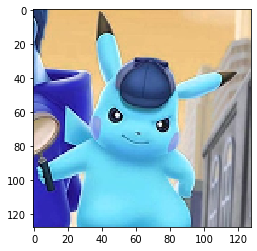

In [369]:
plt.imshow(X_train[0])

## normalize the data


In [370]:
# Using the function definition

X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

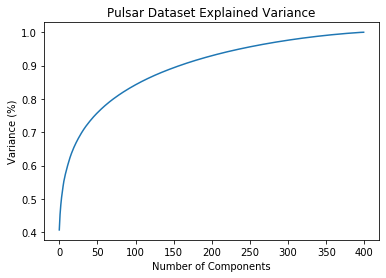

In [371]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=[0, 1])

X_train_norm2D = X_train_norm.reshape(X_train_norm.shape[0],128*128*3)
X_test_norm2D = X_test_norm.reshape(X_test_norm.shape[0],128*128*3)

X_train_scaled = scaler.fit_transform(X_train_norm2D)
X_test_scaled = scaler.fit_transform(X_test_norm2D)

#Fitting the PCA algorithm with X_train
pca = PCA().fit(X_train_scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [372]:
# Choosing no. of importratnt features to proceed further ( > 95% data preserved with that)

pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)


In [373]:
X_train_pca.shape, X_test_pca.shape,y_train.shape,y_test.shape

((400, 300), (544, 300), (400,), (544,))

## train your classification model based on your extracted features


In [409]:
from sklearn import svm

# Setting the hyperparameters for Once Class SVM
# Other combinations: linear, rbf, poly, gamma- 0.001, 0.0001, nu- 0.25, 0.5, 0.75, 0.95
oneclass = svm.OneClassSVM(kernel='linear', gamma=0.0001, nu=0.5)
oneclass.fit(X_train_pca)
test_pred = oneclass.predict(X_test_pca)
unique, counts = np.unique(test_pred, return_counts=True)
print (np.asarray((unique, counts)).T)

[[ -1 245]
 [  1 299]]


## test it against the test set and get performance scores (accuracy, f1, etc ...)


In [430]:
TP,FN,FP,TN = scores(y_test,test_pred)
print ("True Positives:", TP, "\nFalse Negatives:", FN, "\nFalse Positives:", FP, "\nTrue Negatives:", TN)


True Positives: 44 
False Negatives: 0 
False Positives: 255 
True Negatives: 245


In [414]:
# Performance Matrix

accuracy = (TP+TN)/(TP+FN+FP+TN)
print ("\nAccuracy:",accuracy)
sensitivity = TP/(TP+FN)
print ("\nSensitivity",sensitivity)
specificity = TN/(TN+FP)
print ("\nSpecificity",specificity)


Accuracy: 0.53125

Sensitivity 1.0

Specificity 0.49


In [437]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, test_pred, average='macro')  
print("F1 Score: ", f1)

F1 Score:  0.07678883071553229


## save your trained model as a pickle file


In [417]:
import pickle
# save the model to pickle file
filename = 'pikachu.sav'
pickle.dump(oneclass, open(filename, 'wb'))

In [418]:
# load the model from saved file
loaded_model = pickle.load(open(filename, 'rb'))

## design your code so that we can later use some external images to test on your saved model (IMPORTANT!)


In [ ]:
# To test on other test data "test_data"

test_output = oneclass.predict(test_data)
# 1: pikachu
# -1/0: not pikachu

## Bonus: k-fold validation

In [436]:
# Using k-fold cross validation here

from sklearn.model_selection import KFold

fold_scores = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X1):
    X_train_fold, X_test_fold, y_train_fold, y_test_fold = X1[train_index], np.concatenate((X1[test_index],X2), axis=0), y1[train_index], np.concatenate((y1[test_index],y2), axis=0)
    oneclass.fit(X_train_fold.reshape(X_train_fold.shape[0],128*128*3), X_test_fold.reshape(X_test_fold.shape[0],128*128*3))
    test_pred_fold = oneclass.predict(X_test_fold.reshape(X_test_fold.shape[0],128*128*3))
    TP,FN,FP,TN = scores(y_test_fold,test_pred_fold)
    accuracy = (TP+TN)/(TP+FN+FP+TN)
    fold_scores.append(accuracy)
print(fold_scores)
print(np.mean(fold_scores))


[0.9921568627450981, 0.9921568627450981, 0.9901960784313726, 0.9901768172888016, 0.9921414538310412, 0.9921414538310412, 0.9901768172888016, 0.9901768172888016, 0.9921414538310412, 0.9901768172888016]
0.9911641434569898
